In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
import seaborn as sns

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency
import re
import time

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

In [2]:
from sklearn.datasets import load_iris
from sklearn import datasets

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [25]:
from sklearn import tree
from sklearn.datasets import make_classification

from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import xgboost    #1.7.5버전
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer

from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_boston

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

from scipy.stats import skew

1. 데이터 탐색 (데이터 형 확인, 각 피처들 타입, NULL값, 분포도 등)
2. 데이터 분포 형태에 따른 로그변환
3. 널값 처리 & 인코딩
4. 모델 학습/예측/평가(rmse수치)
5. 컬럼별 회귀계수 확인 및 시각화
6. cross_val_score교차검증 수행
7. 그리드서치cv 최적 파라미터 찾기
8. 파라미터 수정 및 재평가(rmse)

9. 왜곡 탐색(skew)
	ㄴ왜곡 정도가 심한 칼럼 -> 로그변환 -> 원핫인코딩
10. 회귀계수 높은 칼럼들 -> 이상치 확인 및 제거
11. 회귀트리 학습/예측/평가 -> 최적 하이퍼파라미터 조정
12. feature_importances 확인
	ㄴ중요도가 높은 칼럼은 이상치, 데이터 분포 등 확인
13. 회귀 모델들 예측 결과 혼합 -> 최종 예측

In [4]:
df_org = pd.read_csv(r'D:\hmkd1\m1_programming\[8] 머신러닝\house_price.csv')
df = df_org.copy()
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
# 데이터 형 확인
df.shape

(1460, 81)

In [6]:
# 전체 피처들의 타입
df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

#### 로그변환 및 null값 처리, 인코딩

In [7]:
# 널값확인, 내림차순, 널값이 1개 이상인 칼럼만
df.isnull().sum().sort_values(ascending=False)[df.isnull().sum()>0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

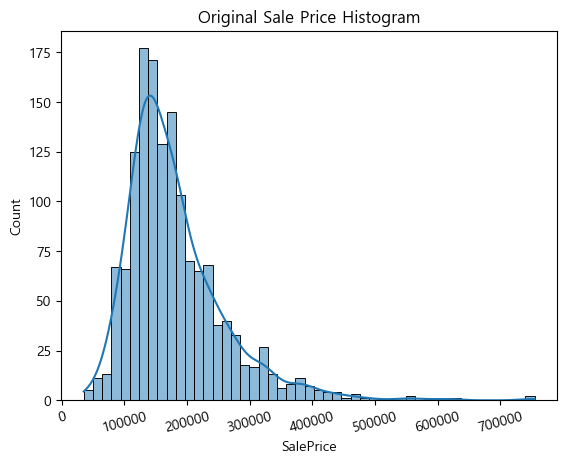

In [8]:
# 로그변환 전
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)

sns.histplot(df['SalePrice'], kde=True)
plt.show()

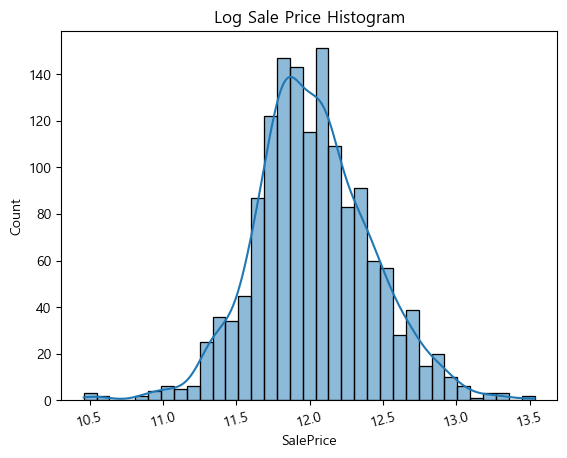

In [9]:
# 로그변환 후
plt.title('Log Sale Price Histogram')
plt.xticks(rotation=15)

saleprice_log = np.log1p(df['SalePrice'])
sns.histplot(saleprice_log, kde=True)
plt.show()

In [10]:
#칼럼 로그변환
df['SalePrice'] = np.log1p(df['SalePrice'])

# 널값이 너무 많은/ 불필요한 칼럼 삭제
df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)
# 그 외 널값 있는 칼럼 대체 (숫자형->평균대체)
df.fillna(df.mean(), inplace=True)

In [11]:
df.isnull().sum().sort_values(ascending=False)
# 문자형은 아직 널값이 남아있음 
#-> 원핫인코딩을 하면 알아서 처리됨(전부 0으로 들어가니까)

GarageType      81
GarageCond      81
GarageFinish    81
GarageQual      81
BsmtFinType2    38
                ..
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
MSZoning         0
SalePrice        0
Length: 75, dtype: int64

In [12]:
print(f'원핫 인코딩 전 데이터 형태: {df.shape}')
df_onehot = pd.get_dummies(df)   #원핫인코딩(문자형만 됨)

print(f'원핫 인코딩 후 데이터 형태: {df_onehot.shape}')

원핫 인코딩 전 데이터 형태: (1460, 75)
원핫 인코딩 후 데이터 형태: (1460, 271)


In [13]:
df_onehot.isnull().sum().sum()
# DF의 모든 널값이 처리됨

0

In [14]:
print(f'원래: \n{df.dtypes.value_counts()}\n')
print(f'원핫 후: \n{df_onehot.dtypes.value_counts()}')
#원핫 후 유닛이 늘어난 걸 볼 수 있음

원래: 
object     38
int64      33
float64     4
dtype: int64

원핫 후: 
uint8      234
int64       33
float64      4
dtype: int64


### 선형회귀 모델의 학습/예측/평가

In [15]:
def get_rmse(model):
    pred = model.predict(xtest)
    mse = mean_squared_error(ytest, pred)
    rmse = np.sqrt(mse)
    
    print(f'''{model.__class__.__name__} 로그변환 된 RMSE: {np.round(rmse, 3)}''')
    return rmse

def get_rmses(models):
    rmse_list=[]
    for i_model in models:
        rmse = get_rmse(i_model)
        rmse_list.append(rmse)
    return rmse_list

In [16]:
xdf = df_onehot.drop('SalePrice', axis=1)
ydf = df_onehot.SalePrice
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, 
                            test_size=0.2, random_state=156)

lrr = LinearRegression(); lrr.fit(xtrain, ytrain)
rd = Ridge(); rd.fit(xtrain, ytrain)
las = Lasso(); las.fit(xtrain, ytrain)

model_list = [lrr, rd, las]
rmse_list = get_rmses(model_list)
rmse_list

LinearRegression 로그변환 된 RMSE: 0.132
Ridge 로그변환 된 RMSE: 0.128
Lasso 로그변환 된 RMSE: 0.176


[0.1318957657915435, 0.1275084633405304, 0.17628250556471406]

In [17]:
# 컬럼별 회귀계수들
coef = pd.Series(lrr.coef_, index=xdf.columns)
coef

MSSubClass              -0.000488
LotFrontage              0.000390
LotArea                  0.000002
OverallQual              0.041866
OverallCond              0.032077
                           ...   
SaleCondition_AdjLand   -0.076029
SaleCondition_Alloca     0.028081
SaleCondition_Family    -0.063272
SaleCondition_Normal    -0.000464
SaleCondition_Partial    0.167346
Length: 270, dtype: float64

In [18]:
def coef_topbottom(model):  #상하위 10개만 추출하기
    coef = pd.Series(model.coef_, index=xdf.columns)
    
    high = coef.sort_values(ascending=False).head(10)
    low = coef.sort_values(ascending=False).tail(10)
    return high, low

In [19]:
coef_topbottom(lrr)
coef_topbottom(rd)
coef_topbottom(las)

(YearBuilt       0.002551
 YearRemodAdd    0.001191
 GarageArea      0.000379
 GrLivArea       0.000305
 WoodDeckSF      0.000183
 TotalBsmtSF     0.000158
 ScreenPorch     0.000154
 BsmtFinSF1      0.000029
 MasVnrArea      0.000019
 2ndFlrSF        0.000017
 dtype: float64,
 Condition2_RRAe         -0.000000e+00
 Condition2_RRAn         -0.000000e+00
 Condition2_RRNn         -0.000000e+00
 BldgType_1Fam            0.000000e+00
 BldgType_2fmCon         -0.000000e+00
 BldgType_Duplex         -0.000000e+00
 BldgType_Twnhs          -0.000000e+00
 SaleCondition_Partial    0.000000e+00
 MiscVal                 -6.186043e-07
 PoolArea                -6.327429e-05
 dtype: float64)

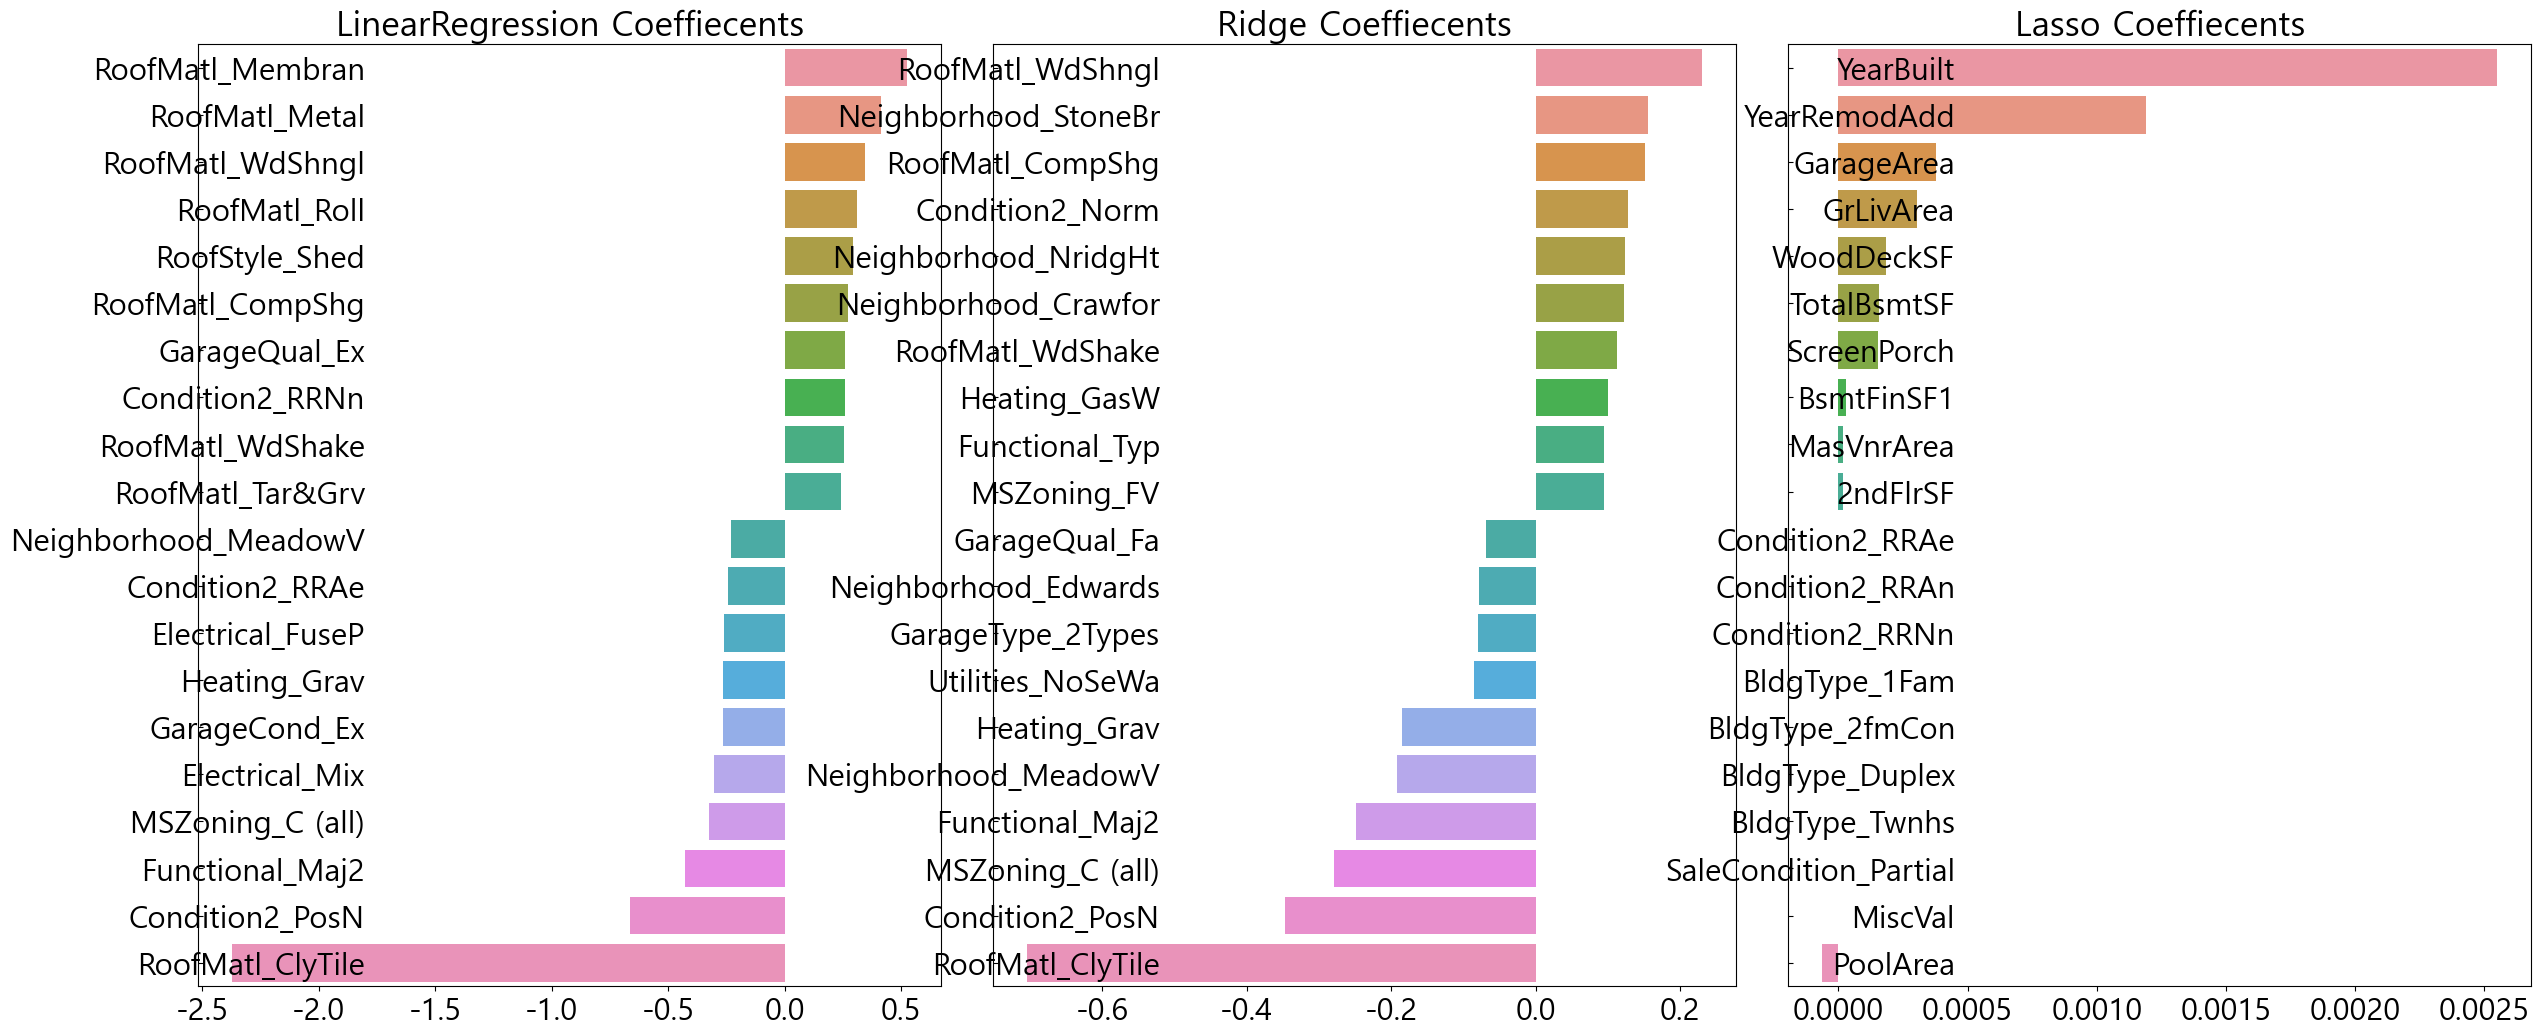

In [20]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    
    for i_num, model in enumerate(models):
        # 상하위 10개 회귀계수
        coef_high, coef_low = coef_topbottom(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        # 타이틀, 축 이름
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        
        # 라벨, 폰트
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 각 모델의 회귀계수 시각화
models = [lrr, rd, las]
visualize_coefficient(models)

In [21]:
# 교차검증
def get_avg_rmse(models):
    for i_model in models:
        rmse_list = np.sqrt(-cross_val_score(i_model, xdf, ydf,
                         scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{i_model.__class__.__name__} 폴드 RMSE값 리스트: {np.round(rmse_list,3)}')
        print(f'{i_model.__class__.__name__} 폴드 RMSE 평균값: {np.round(rmse_avg,3)}\n')
        
models = [lrr, rd, las]
get_avg_rmse(models)

LinearRegression 폴드 RMSE값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression 폴드 RMSE 평균값: 0.155

Ridge 폴드 RMSE값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge 폴드 RMSE 평균값: 0.144

Lasso 폴드 RMSE값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso 폴드 RMSE 평균값: 0.198



In [22]:
# 하이퍼파라미터 튜닝
def best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                    scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(xdf,ydf)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} 5cv 시 최적 평균 RMSE값: {np.round(rmse, 4)}, 최적 alpha: {grid_model.best_params_}')
    
    return grid_model.best_estimator_

rd_param = {'alpha':[0.05, 0.1, 1, 5, 8 ,10, 12, 15, 20]}
las_param = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}

best_rd = best_params(rd, rd_param)
best_las = best_params(las, las_param)

Ridge 5cv 시 최적 평균 RMSE값: 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5cv 시 최적 평균 RMSE값: 0.142, 최적 alpha: {'alpha': 0.001}


그리드서치cv 최적 파라미터 수정 전
- LinearRegression 로그변환 된 RMSE: 0.132
- Ridge 로그변환 된 RMSE: 0.128
- Lasso 로그변환 된 RMSE: 0.176
[0.1318957657915435, 0.1275084633405304, 0.17628250556471406]

LinearRegression 로그변환 된 RMSE: 0.132
Ridge 로그변환 된 RMSE: 0.124
Lasso 로그변환 된 RMSE: 0.12


[0.1318957657915435, 0.12387044279987389, 0.11995999974065168]

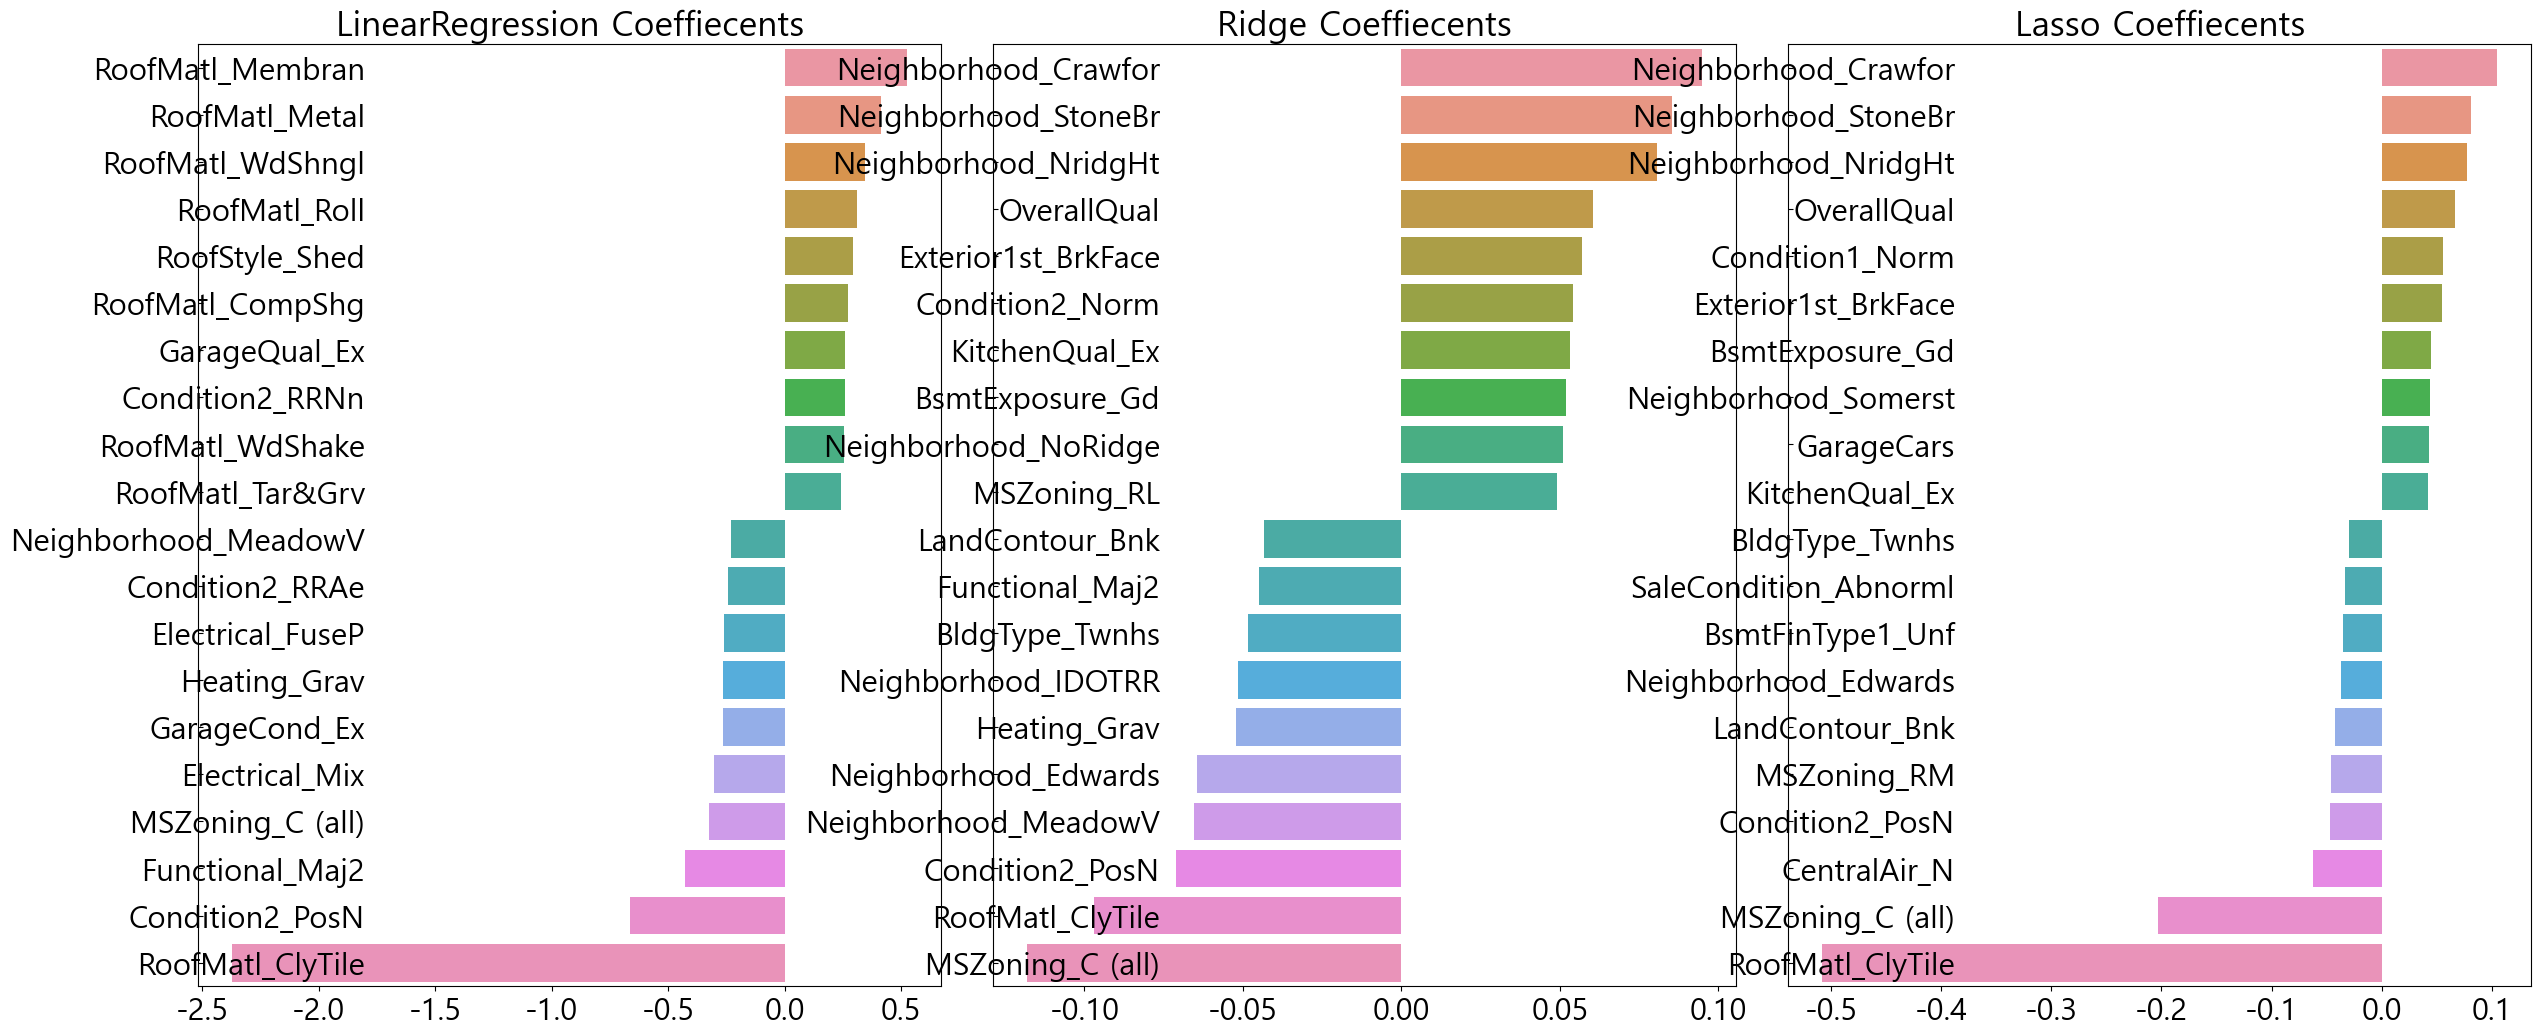

In [23]:
# 그리드서치cv로 나온 최적 파라미터 값 입력 후
lrr = LinearRegression(); lrr.fit(xtrain, ytrain)
rd_al = Ridge(alpha=12); rd_al.fit(xtrain, ytrain)
las_al = Lasso(alpha=0.001); las_al.fit(xtrain, ytrain)

models = [lrr, rd_al, las_al]
rmse_list = get_rmses(models)    #rmse
visualize_coefficient(models)    #회귀계수 시각화

rmse_list

1. 데이터 탐색 (데이터 형 확인, 각 피처들 타입, NULL값, 분포도 등)
2. 데이터 분포 형태에 따른 로그변환(레이블의 분포가 왜곡이 되어 있어서 -> 정규분포에 가까운 형태여야 모델 성능이 잘 나옴)
3. 널값 처리 & 인코딩(문자->숫자)
4. 모델 학습/예측/평가(rmse수치)
5. 컬럼별 회귀계수 확인 및 시각화
6. cross_val_score교차검증 수행
7. 그리드서치cv 최적 파라미터 찾기
8. 파라미터 수정 및 재평가(rmse)

#### 왜곡 -> 로그변환 및 원핫

In [24]:
from scipy.stats import skew

idx = df.dtypes[df.dtypes != 'object'].index   #숫자형 칼럼 추출
skew_col = df[idx].apply(lambda x: skew(x))   #각 칼럼에 skew() 적용
skew_col_top = skew_col[skew_col>1]   #skew(왜곡) 정도가 1이상인 칼럼만 추출

skew_col_top.sort_values(ascending=False)   #내림차순 정렬

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [34]:
log_skew = df.copy()

skew_list = skew_col_top.index   #왜곡이 1이상인 칼럼들 
log_skew[skew_list] = np.log1p(log_skew[skew_list])   #로그변환

log_skew[skew_list]

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.000000,6.753438,6.753438,0.0,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.000000,7.141245,7.141245,0.0,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.000000,6.825460,6.825460,0.0,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.000000,6.629363,6.869014,0.0,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.000000
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.000000,7.044033,7.044033,0.0,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.110874,4.143135,8.976894,0.000000,0.000000,0.000000,6.860664,6.860664,0.0,7.407318,0.000000,0.693147,0.000000,3.713572,0.000000,0.0,0.0,0.0,0.000000
1456,3.044522,4.454347,9.486152,4.787492,6.673298,5.099866,7.341484,7.637234,0.0,7.637234,0.000000,0.693147,5.857933,0.000000,0.000000,0.0,0.0,0.0,0.000000
1457,4.262680,4.204693,9.109746,0.000000,5.620401,0.000000,7.050123,7.080868,0.0,7.758333,0.000000,0.693147,0.000000,4.110874,0.000000,0.0,0.0,0.0,7.824446
1458,3.044522,4.234107,9.181735,0.000000,3.912023,6.937314,6.983790,6.983790,0.0,6.983790,0.000000,0.693147,5.905362,0.000000,4.727388,0.0,0.0,0.0,0.000000


In [36]:
# skew가 높은 칼럼을 로그변환 한 후, 다시 원핫 인코딩 적용
df_onehot = pd.get_dummies(log_skew)
xdf = df_onehot.drop('SalePrice', axis=1)
ydf = df_onehot.SalePrice
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, test_size=0.2, random_state=156)

# 최적 하이퍼파라미터 및 rmse 출력
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
best_rd = best_params(rd, ridge_params)
best_las = best_params(las, lasso_params)

Ridge 5cv 시 최적 평균 RMSE값: 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5cv 시 최적 평균 RMSE값: 0.1252, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그변환 된 RMSE: 0.128
Ridge 로그변환 된 RMSE: 0.122
Lasso 로그변환 된 RMSE: 0.119


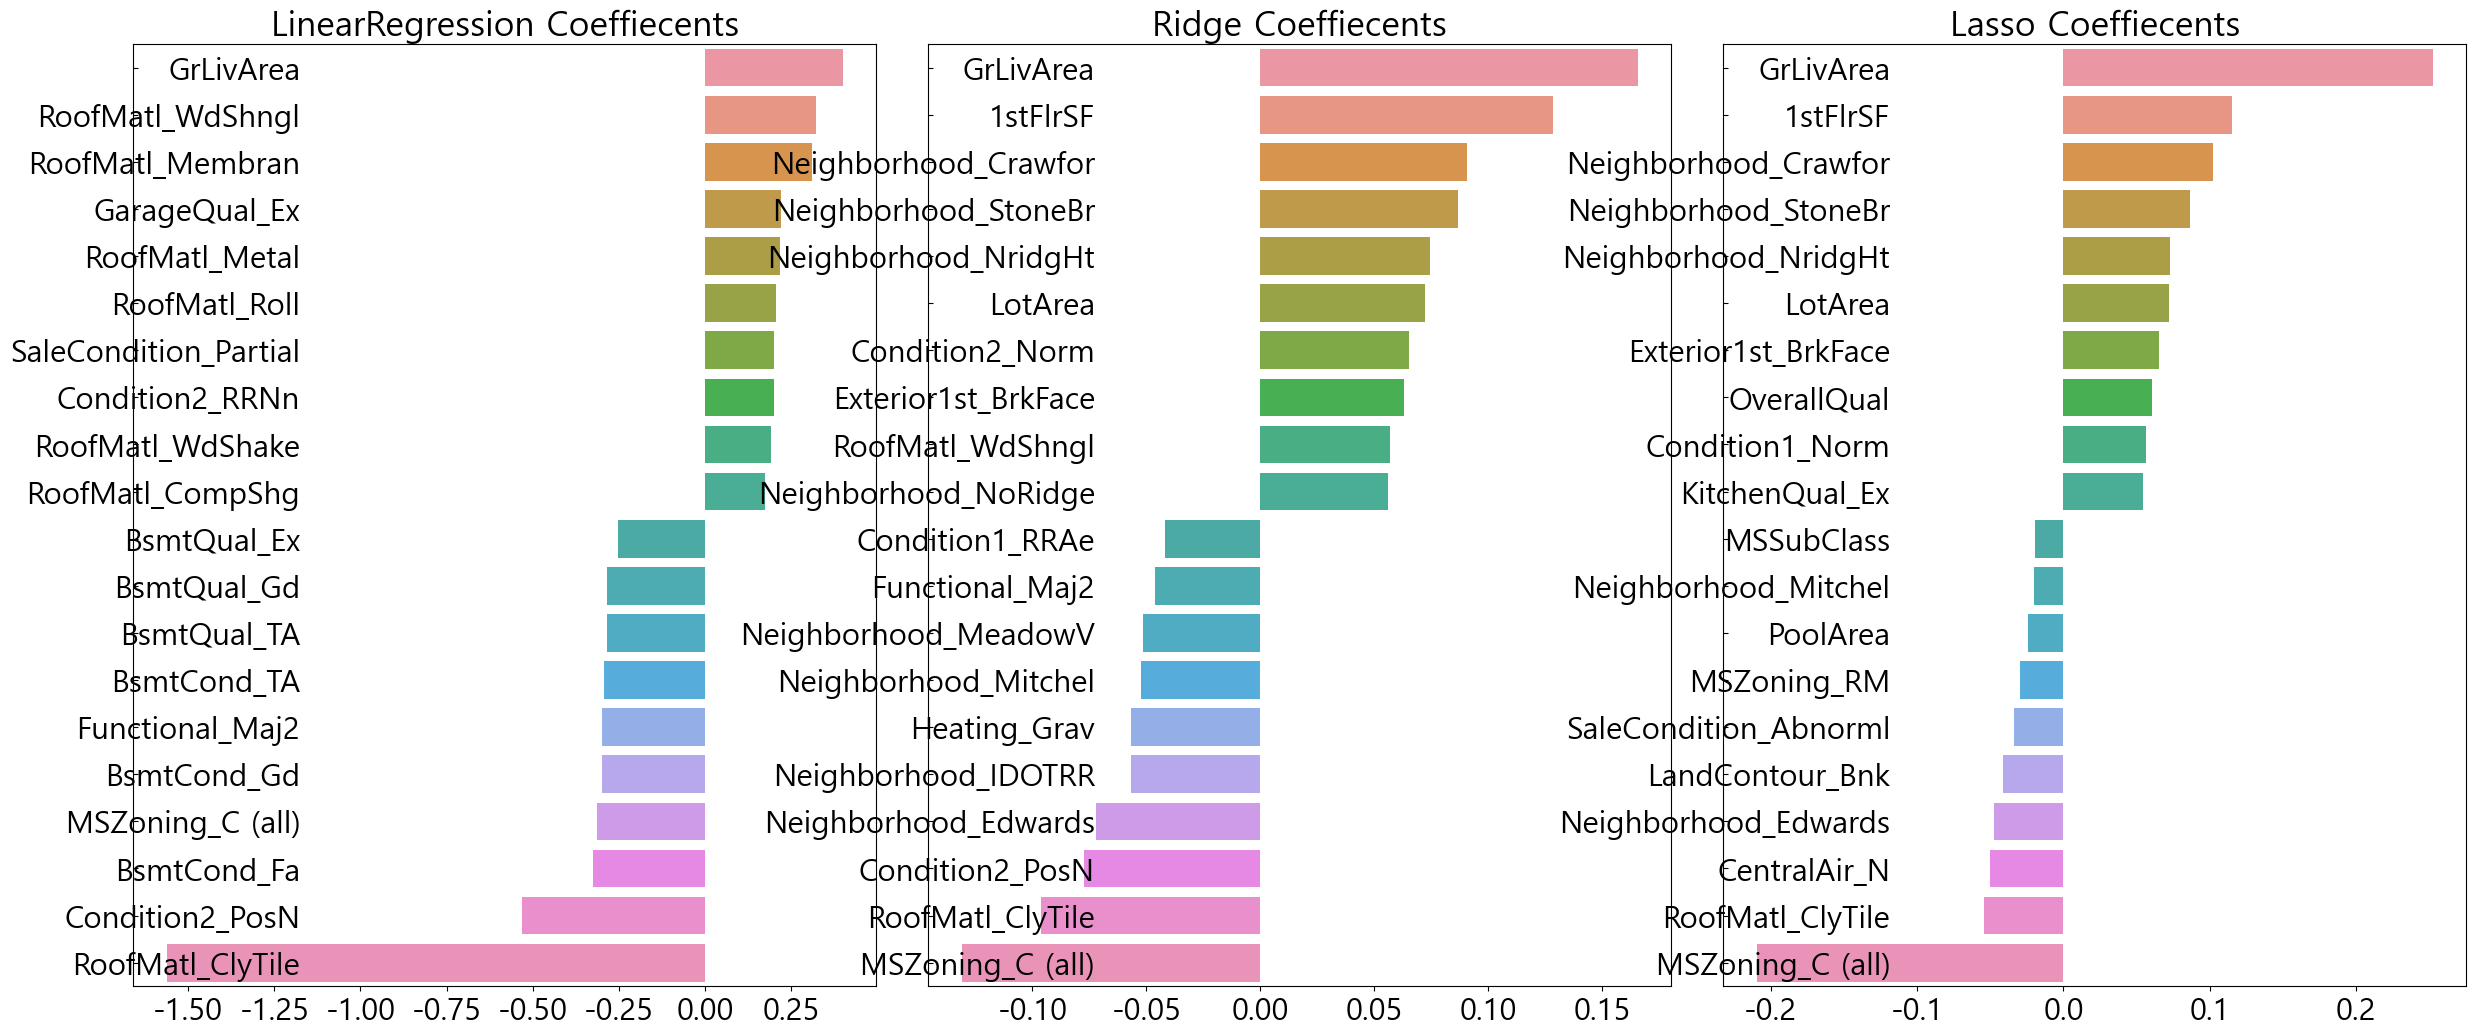

In [38]:
# 최적화 알파값으로 학습/예측/평가 수행
lrr = LinearRegression(); lrr.fit(xtrain, ytrain)
rd = Ridge(alpha=10); rd.fit(xtrain, ytrain)
las = Lasso(alpha=0.001); las.fit(xtrain, ytrain)

# 모든 모델의 RMSE 출력
model_list = [lrr, rd, las]
rmse_list = get_rmses(model_list)

# 모든 모델의 회귀계수 시각화
visualize_coefficient(model_list)

#### 이상치제거

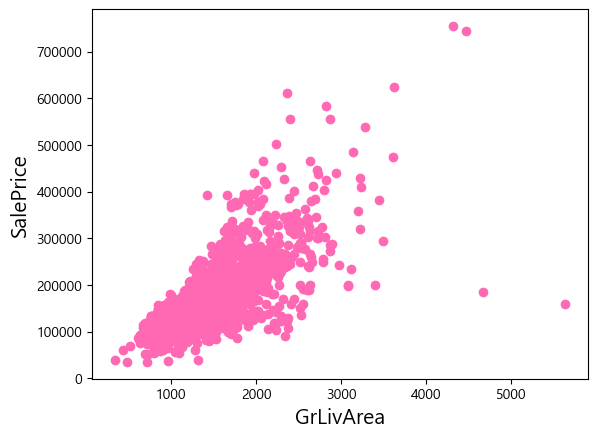

In [44]:
plt.scatter(x=df_org['GrLivArea'], y=df_org['SalePrice'], color='hotpink')
plt.xlabel('GrLivArea', fontsize=15)
plt.ylabel('SalePrice', fontsize=15)
plt.show()

In [46]:
cond1 = df_onehot['GrLivArea'] > np.log1p(4000)
cond2 = df_onehot['SalePrice'] < np.log1p(500000)
idx = df_onehot[cond1&cond2].index    #이상치 인덱스

print(f'아웃라이어 레코드 인덱스: {idx.values}')
print(f'아웃라이어 삭제 전 데이터프레임 shape: {df_onehot.shape}')

df_onehot.drop(idx, axis=0, inplace=True)   #이상치 삭제
print(f'아웃라이어 삭제 후 데이터프레임 shape: {df_onehot.shape}')

아웃라이어 레코드 인덱스: [ 523 1298]
아웃라이어 삭제 전 데이터프레임 shape: (1460, 271)
아웃라이어 삭제 후 데이터프레임 shape: (1458, 271)


In [47]:
# 이상치 삭제 후 다시 최적 하이퍼파라미터 및 rmse 출력
xdf = df_onehot.drop('SalePrice', axis=1)
ydf = df_onehot.SalePrice
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
best_rd = best_params(rd, ridge_params)
best_las = best_params(las, lasso_params)

Ridge 5cv 시 최적 평균 RMSE값: 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5cv 시 최적 평균 RMSE값: 0.1122, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그변환 된 RMSE: 0.129
Ridge 로그변환 된 RMSE: 0.103
Lasso 로그변환 된 RMSE: 0.1


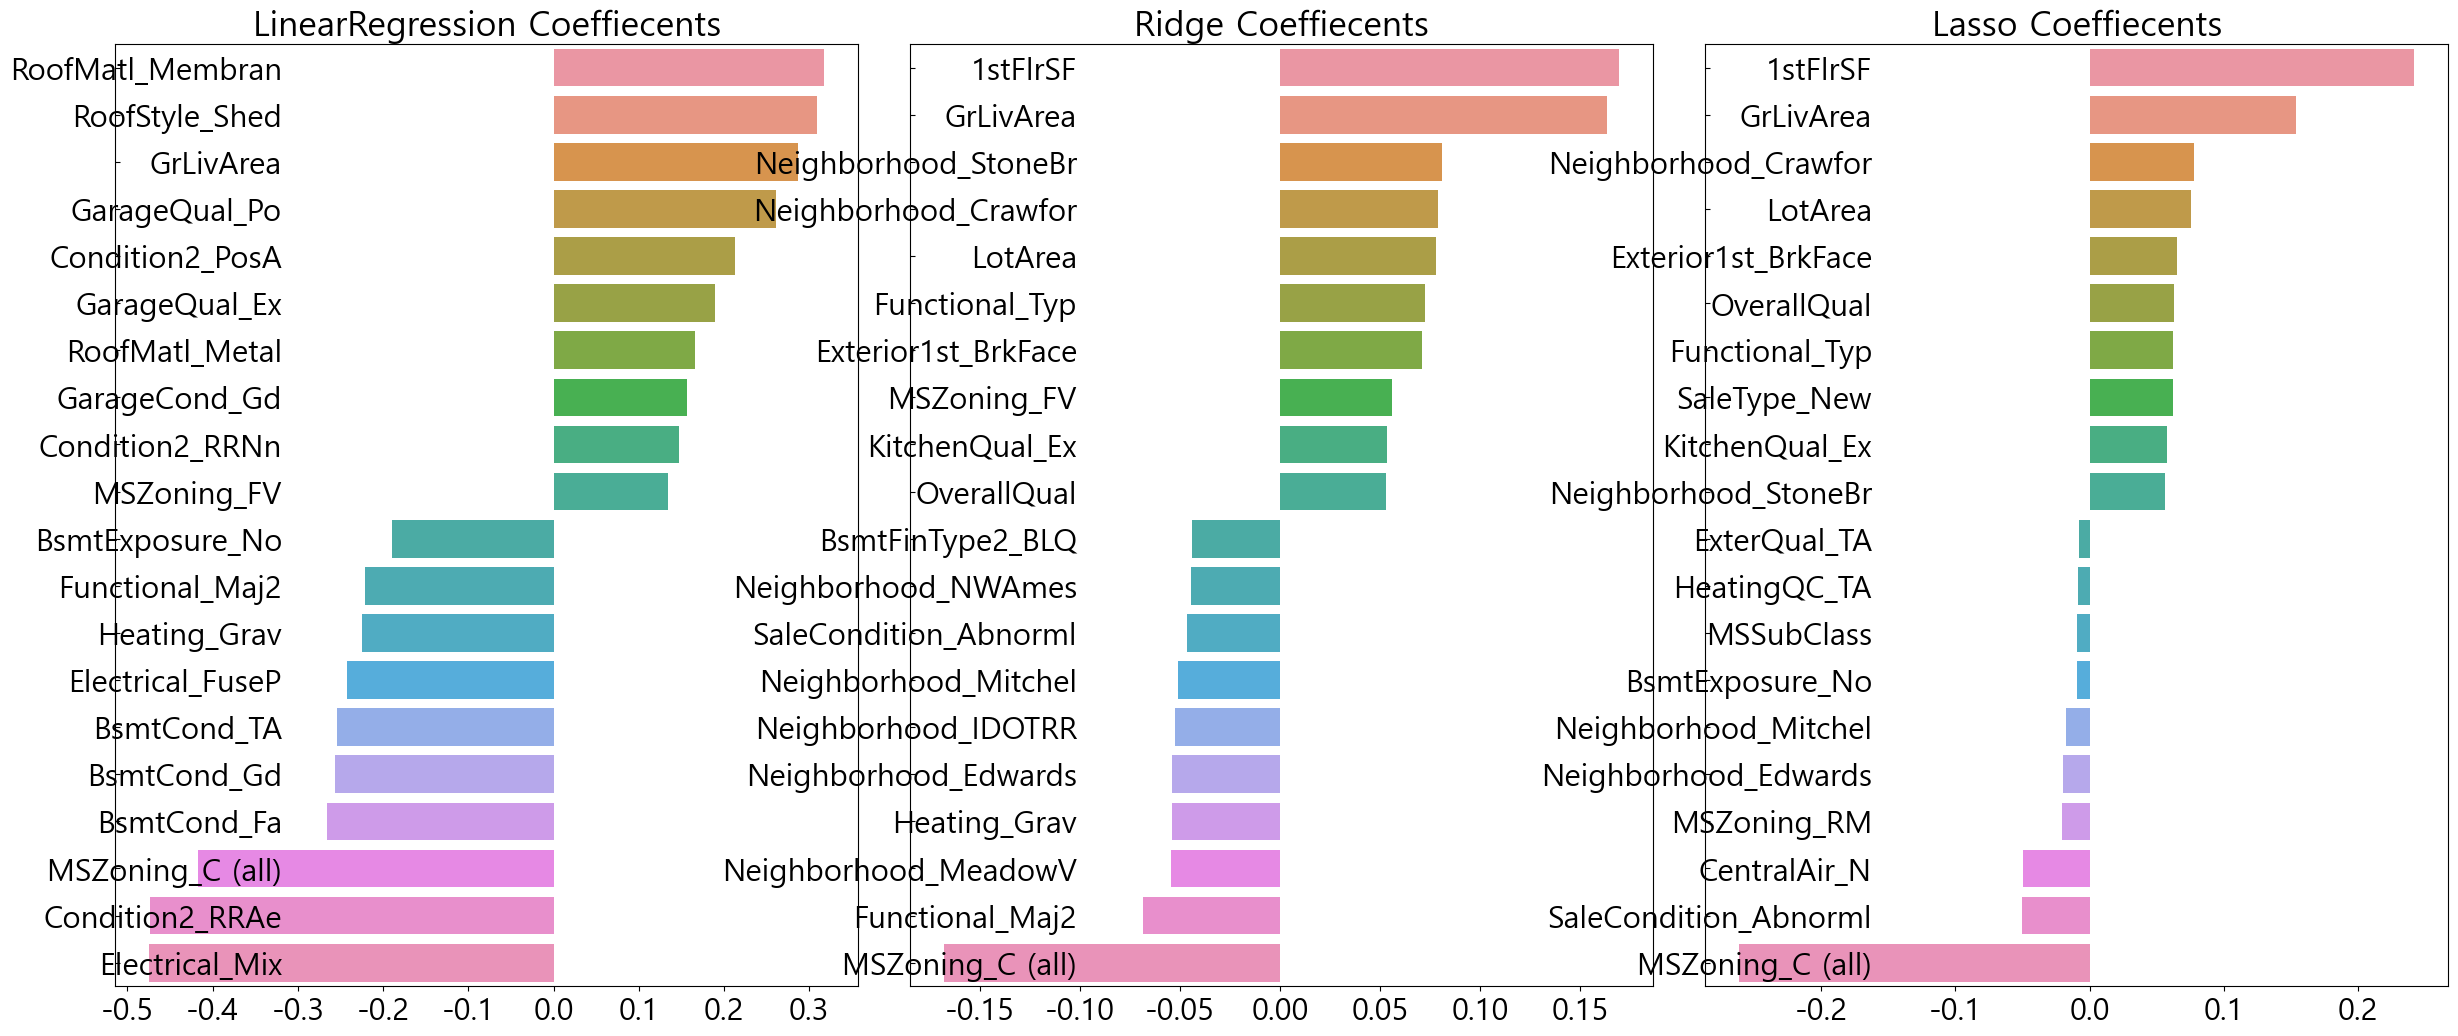

In [48]:
# 최적화 알파값으로 학습/예측/평가 수행
lrr = LinearRegression(); lrr.fit(xtrain, ytrain)
rd = Ridge(alpha=8); rd.fit(xtrain, ytrain)
las = Lasso(alpha=0.001); las.fit(xtrain, ytrain)

# 모든 모델의 RMSE 출력
model_list = [lrr, rd, las]
rmse_list = get_rmses(model_list)

# 모든 모델의 회귀계수 시각화
visualize_coefficient(model_list)

#### 회귀 트리 학습/예측/평가

In [49]:
# XGB
xgb_param = {'n_estimators':[1000]}
xgbr = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                   colsample_bytree=0.5, subsample=0.8)
best_xgb = best_params(xgbr, xgb_param)

XGBRegressor 5cv 시 최적 평균 RMSE값: 0.1171, 최적 alpha: {'n_estimators': 1000}


In [50]:
# LGBM
lgbm_param = {'n_estimators':[1000]}
lgbmr = LGBMRegressor(n_estimators=1000, learning_rate=0.05, 
                num_leaves=4, subsample=0.6, colsample_bytree=0.5,
                reg_lambda=10, n_jobs=-1)
best_lgbm = best_params(lgbmr, lgbm_param)

LGBMRegressor 5cv 시 최적 평균 RMSE값: 0.1165, 최적 alpha: {'n_estimators': 1000}


- LGBM은 XGB와 성능은 비슷하면서 시간은 훨씬 적게 걸림 (LGBM은 리프중심으로 알고리즘이 작동해서 가능한 것)

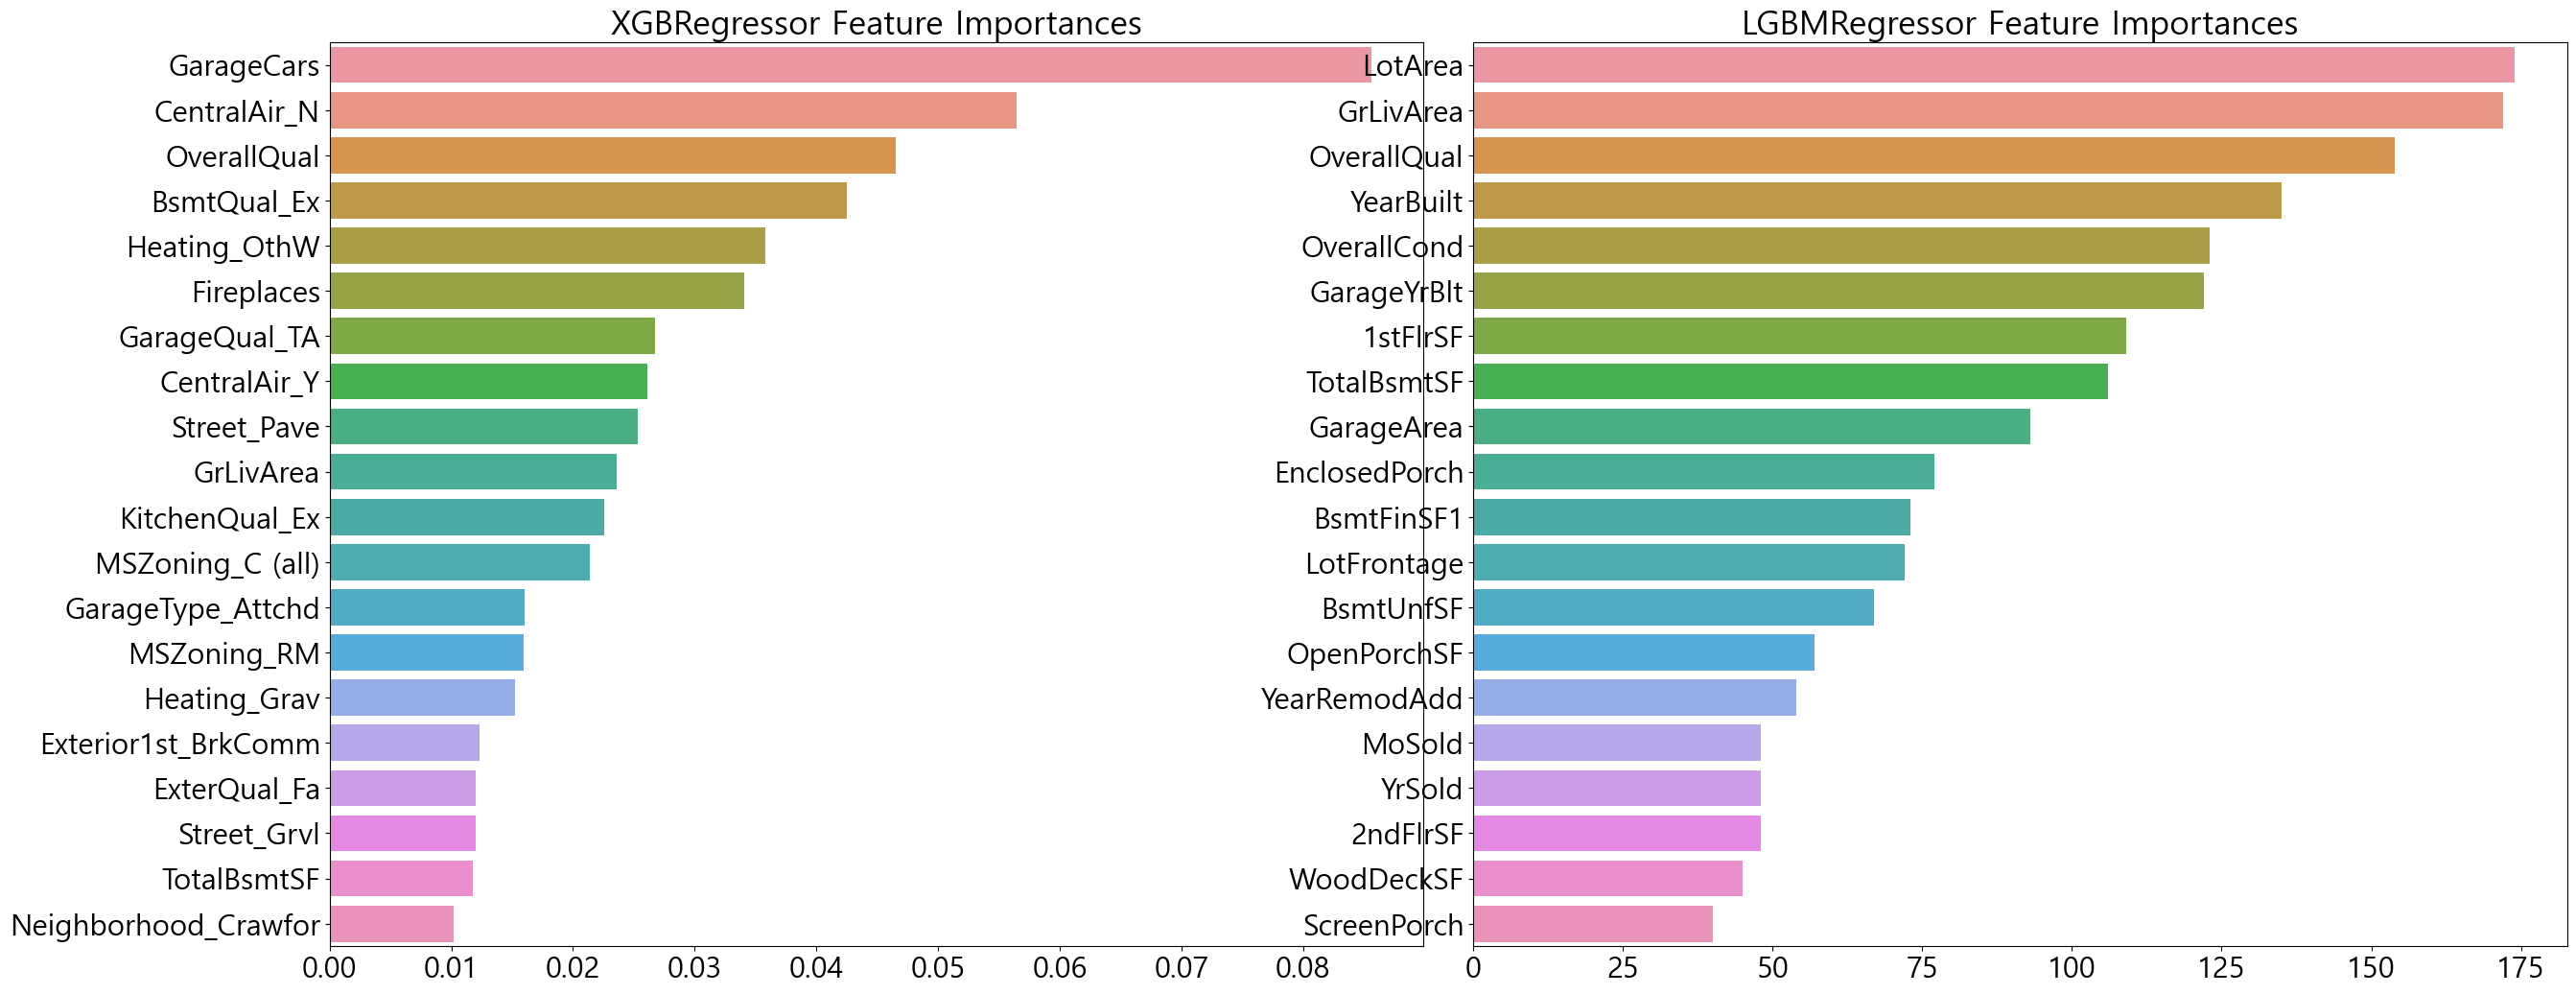

In [53]:
# 모델의 중요도 상위 20개 피처명과 중요도값을 시리즈로
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=xdf.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

- 중요한 몇몇 칼럼들은 이상치도 보고, 데이터 분포도 보고(왜곡정도), 탐색을 좀 더 깊이 할 것

#### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [57]:
def get_rmse_pred(preds):
    for k in preds.keys():
        pred_value = preds[k]
        mse = mean_squared_error(ytest, pred_value)
        rmse = np.sqrt(mse)
        print(f'{k} 모델의 RMSE: {rmse}')
    
# 개별모델의 학습
rd = Ridge(alpha=8); rd.fit(xtrain, ytrain)
las = Lasso(alpha=0.001); las.fit(xtrain, ytrain)
# 개별모델의 예측
rd_pred = lrr.predict(xtest)
las_pred = las.predict(xtest)

# 개별모델 예측값 혼합 -> 최종 예측값 도출
pred = (0.4*rd_pred) + (0.6*las_pred)
preds = {'최종 혼합': pred, 'Ridge':rd_pred, 'Lasso':las_pred}

# 최종 혼합모델, 개별모델의 RMSE 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10440199150941401
Ridge 모델의 RMSE: 0.12864941604870397
Lasso 모델의 RMSE: 0.1002417046089003


In [61]:
# XGB + LGBM 혼합 RMSE
xgbr = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                   colsample_bytree=0.5, subsample=0.8)
xgbr.fit(xtrain, ytrain)
lgbmr = LGBMRegressor(n_estimators=1000, learning_rate=0.05, 
                num_leaves=4, subsample=0.6, colsample_bytree=0.5,
                reg_lambda=10, n_jobs=-1)
lgbmr.fit(xtrain, ytrain)

xgbr_pred = xgbr.predict(xtest)
lgbmr_pred = lgbmr.predict(xtest)

pred = (0.5*xgbr_pred) + (0.5*lgbmr_pred)   #혼합
preds = {'최종 혼합': pred, 'XGBRegressor':xgbr_pred, 'LGBMRegressor':lgbmr_pred}

get_rmse_pred(preds)   #출력

최종 혼합 모델의 RMSE: 0.10186397087165838
XGBRegressor 모델의 RMSE: 0.10738295638346222
LGBMRegressor 모델의 RMSE: 0.10296653528637886


9. 왜곡 탐색(skew)
	ㄴ왜곡 정도가 심한 칼럼 -> 로그변환 -> 원핫인코딩
10. 회귀계수 높은 칼럼들 -> 이상치 확인 및 제거
11. 회귀트리 학습/예측/평가 -> 최적 하이퍼파라미터 조정
12. feature_importances 확인
	ㄴ중요도가 높은 칼럼은 이상치, 데이터 분포 등 확인
13. 회귀 모델들 예측 결과 혼합 -> 최종 예측